In [97]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!pip install pymorphy2
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

np.random.seed(42)
random.seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [98]:
import warnings
warnings.filterwarnings('ignore')

In [99]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Работа с данными

In [100]:
#train
train = pd.read_csv('/content/drive/MyDrive/B_f_train.csv')
#test
test = pd.read_csv('/content/drive/MyDrive/B_f_val.csv')

In [101]:
data = train.append(test)
data.shape

(8337, 4)

In [102]:
data

,title,content,label,link
0,An Independent Voter Guide to The Impeachment ...,The impeachment trial ofÂ President Donald J. ...,center,ivn.us
1,Witnesses of the Unseen: Breaking Out of the T...,Criminal justice in the United States has a lo...,center,ivn.us
2,Abolishing The Electoral College Could Have Ma...,"Itâs been a month since Election Day, and we...",center,ivn.us
3,Mandate: San Diego Voters Send Strong Message ...,"San Diego, Calif.- In the opaque world of poli...",center,ivn.us
4,Chollas Creek Neighborhood Fights to Save its ...,This is the second installment of a two-part s...,center,ivn.us
...,...,...,...,...
907,Rep. Marjorie Taylor Greene Introduces a Bill ...,Congresswoman Marjorie Taylor Greene ( R-GA ) ...,right,thetruthaboutguns.com
908,"Joe Biden is Selling Guns at a Blistering, Wor...",Joe Biden may not know what time it is at any ...,right,thetruthaboutguns.com
909,A Sign of Things to Come? Gun Control Bill Fai...,"As we mentioned yesterday , firearm sales — in...",right,thetruthaboutguns.com
910,Gear Review: Q Side Chick Rifle Chassis,I have to admit that I really never knew much ...,right,thetruthaboutguns.com


Удаление NaN

In [103]:
train = train.dropna()
test = test.dropna()
data = data.dropna()

In [104]:
data

,title,content,label,link
0,An Independent Voter Guide to The Impeachment ...,The impeachment trial ofÂ President Donald J. ...,center,ivn.us
1,Witnesses of the Unseen: Breaking Out of the T...,Criminal justice in the United States has a lo...,center,ivn.us
2,Abolishing The Electoral College Could Have Ma...,"Itâs been a month since Election Day, and we...",center,ivn.us
3,Mandate: San Diego Voters Send Strong Message ...,"San Diego, Calif.- In the opaque world of poli...",center,ivn.us
4,Chollas Creek Neighborhood Fights to Save its ...,This is the second installment of a two-part s...,center,ivn.us
...,...,...,...,...
907,Rep. Marjorie Taylor Greene Introduces a Bill ...,Congresswoman Marjorie Taylor Greene ( R-GA ) ...,right,thetruthaboutguns.com
908,"Joe Biden is Selling Guns at a Blistering, Wor...",Joe Biden may not know what time it is at any ...,right,thetruthaboutguns.com
909,A Sign of Things to Come? Gun Control Bill Fai...,"As we mentioned yesterday , firearm sales — in...",right,thetruthaboutguns.com
910,Gear Review: Q Side Chick Rifle Chassis,I have to admit that I really never knew much ...,right,thetruthaboutguns.com


Взглянем на распределение по классам на всех данных

In [105]:
data.label.value_counts()

right     3049
center    2734
left      2264
Name: label, dtype: int64

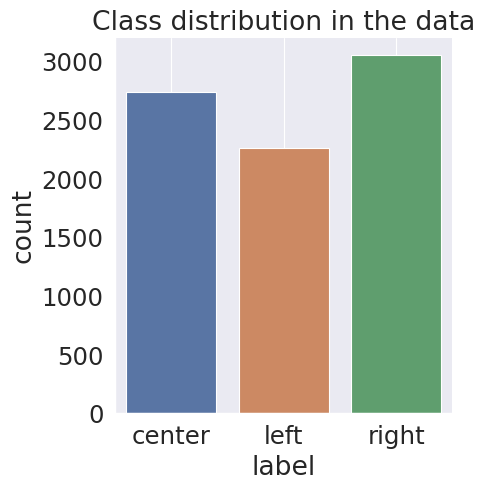

In [106]:
g = sns.catplot(x='label',
                kind="count",
                data=data)
plt.grid()
plt.title("Class distribution in the data");

##  train_test_split

In [107]:
data['link'].value_counts()

ivn.us                      10
learnliberty.org            10
prnewswire.mediaroom.com    10
leadstories.com             10
fortherightnews.com         10
                            ..
star-telegram.com            1
ontarioproud.ca              1
themonitor.com               1
wtae.com                     1
viralthread.com              1
Name: link, Length: 932, dtype: int64

In [108]:
data_links = np.unique(np.array(data['link']))

In [109]:
np.random.shuffle(data_links)

In [110]:
len(data_links)

932

In [111]:
train_links = data_links[:600]
test_links = data_links[600:800]
val_links = data_links[800:]

In [112]:
train = data[data['link'].isin(train_links)]
test = data[data['link'].isin(test_links)]
val = data[data['link'].isin(val_links)]

In [113]:
train.label.value_counts()

right     2051
center    1822
left      1350
Name: label, dtype: int64

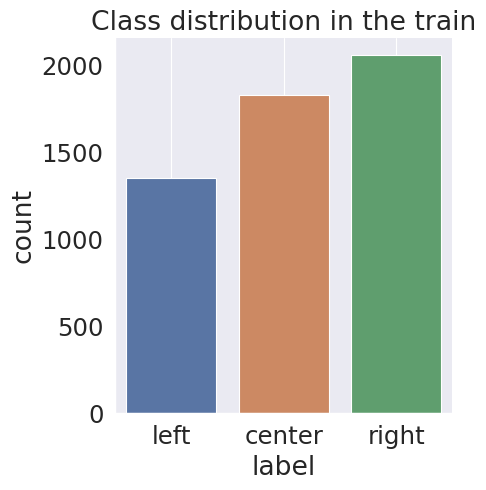

In [114]:
g = sns.catplot(x='label',
                kind="count",
                data=train)
plt.grid()
plt.title("Class distribution in the train");

In [115]:
test.label.value_counts()

right     564
left      536
center    526
Name: label, dtype: int64

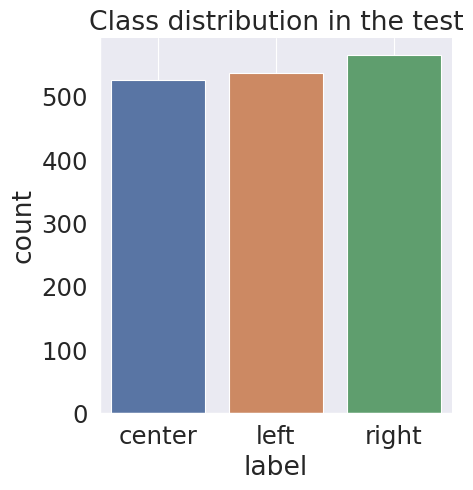

In [116]:
g = sns.catplot(x='label',
                kind="count",
                data=test)
plt.grid()
plt.title("Class distribution in the test");

In [117]:
val.label.value_counts()

right     434
center    386
left      378
Name: label, dtype: int64

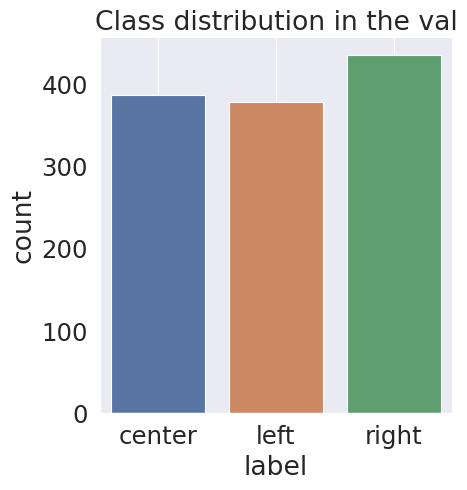

In [118]:
g = sns.catplot(x='label',
                kind="count",
                data=val)
plt.grid()
plt.title("Class distribution in the val");

Создание новой фичи

In [119]:
train['all_text'] = train['title']+train['content']
val['all_text'] = val['title']+val['content']
test['all_text'] = test['title']+test['content']

In [120]:
val.shape 

(1198, 5)

In [121]:
test.shape

(1626, 5)

In [122]:
train.shape

(5223, 5)

#Лемматизация

In [123]:
m = MorphAnalyzer()
regex = re.compile("[A-Za-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]


mystopwords = stopwords.words('english') 
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [124]:
from multiprocessing import Pool as PoolSklearn
#train
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, train['all_text']), total=len(train)))
    
train['lemmas'] = lemmas
train.sample(5)

#val
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, val['all_text']), total=len(val)))  
val['lemmas'] = lemmas
val.sample(5)

#test 
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, test['all_text']), total=len(test)))
    
test['lemmas'] = lemmas
test.sample(5)

100%|██████████| 1626/1626 [00:30<00:00, 52.82it/s]


,title,content,label,link,all_text,lemmas
4251,Past Video Where LeBron James Discusses “White...,"You may not remember this , but there was a Co...",right,revolver.news,Past Video Where LeBron James Discusses “White...,past video lebron james discusses white people...
570,ColumbusMediaInsider: 'Next' Candidates Doom O...,When Dayton Mayor Nan Whaley announced she wou...,left,columbusfreepress.com,ColumbusMediaInsider: 'Next' Candidates Doom O...,columbusmediainsider next candidates doom ohio...
4659,Longmont Jewish center brings light of Hanukka...,Chabad Jewish Center of Longmont invited the w...,center,dailycamera.com,Longmont Jewish center brings light of Hanukka...,longmont jewish center brings light hanukkah v...
7177,Financial Information,The Bauman Foundation The California Endowment...,center,followthemoney.org,Financial InformationThe Bauman Foundation The...,financial informationthe bauman foundation cal...
4140,These are the 40 best photos from April chosen...,The month of April brought back high school fo...,center,dailybulletin.com,These are the 40 best photos from April chosen...,best photos april chosen photographersthe mont...


In [125]:
train = train.dropna()
test = test.dropna()
val = val.dropna()

In [126]:
train

,title,content,label,link,all_text,lemmas
10,An App Called Libby and the Surprisingly Big B...,"Steve Potash , the bearded and bespectacled pr...",left,newyorker.com,An App Called Libby and the Surprisingly Big B...,called libby surprisingly business library boo...
11,The Power of Police Unions,The recent repeal of Section 50-A of the New Y...,left,newyorker.com,The Power of Police UnionsThe recent repeal of...,power police unionsthe recent repeal section y...
12,"Daily Cartoon: Thursday, May 6th",© 2021 Condé Nast .\nAll rights reserved .\nUs...,left,newyorker.com,"Daily Cartoon: Thursday, May 6th© 2021 Condé N...",daily cartoon thursday cond nast rights reserv...
13,What to Stream: Billy Woodberry’s Documentary ...,One of the monstrous failings of American cine...,left,newyorker.com,What to Stream: Billy Woodberry’s Documentary ...,stream billy woodberry documentary poet kaufma...
14,R. & B. Nostalgia Embraces Rap Influence on “C...,"Over the past four decades , hip-hop and R. & ...",left,newyorker.com,R. & B. Nostalgia Embraces Rap Influence on “C...,nostalgia embraces influence cheers best memor...
...,...,...,...,...,...,...
907,Rep. Marjorie Taylor Greene Introduces a Bill ...,Congresswoman Marjorie Taylor Greene ( R-GA ) ...,right,thetruthaboutguns.com,Rep. Marjorie Taylor Greene Introduces a Bill ...,marjorie taylor greene introduces bill abolish...
908,"Joe Biden is Selling Guns at a Blistering, Wor...",Joe Biden may not know what time it is at any ...,right,thetruthaboutguns.com,"Joe Biden is Selling Guns at a Blistering, Wor...",biden selling guns blistering world record pac...
909,A Sign of Things to Come? Gun Control Bill Fai...,"As we mentioned yesterday , firearm sales — in...",right,thetruthaboutguns.com,A Sign of Things to Come? Gun Control Bill Fai...,sign things come control bill fails pass calif...
910,Gear Review: Q Side Chick Rifle Chassis,I have to admit that I really never knew much ...,right,thetruthaboutguns.com,Gear Review: Q Side Chick Rifle ChassisI have ...,gear review side chick rifle chassisi admit re...


In [127]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5223 entries, 10 to 911
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     5223 non-null   object
 1   content   5223 non-null   object
 2   label     5223 non-null   object
 3   link      5223 non-null   object
 4   all_text  5223 non-null   object
 5   lemmas    5223 non-null   object
dtypes: object(6)
memory usage: 285.6+ KB


In [128]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
train['label_enc'] = labelencoder.fit_transform(train['label'])
val['label_enc'] = labelencoder.transform(val['label'])
test['label_enc'] = labelencoder.transform(test['label'])
train

,title,content,label,link,all_text,lemmas,label_enc
10,An App Called Libby and the Surprisingly Big B...,"Steve Potash , the bearded and bespectacled pr...",left,newyorker.com,An App Called Libby and the Surprisingly Big B...,called libby surprisingly business library boo...,1
11,The Power of Police Unions,The recent repeal of Section 50-A of the New Y...,left,newyorker.com,The Power of Police UnionsThe recent repeal of...,power police unionsthe recent repeal section y...,1
12,"Daily Cartoon: Thursday, May 6th",© 2021 Condé Nast .\nAll rights reserved .\nUs...,left,newyorker.com,"Daily Cartoon: Thursday, May 6th© 2021 Condé N...",daily cartoon thursday cond nast rights reserv...,1
13,What to Stream: Billy Woodberry’s Documentary ...,One of the monstrous failings of American cine...,left,newyorker.com,What to Stream: Billy Woodberry’s Documentary ...,stream billy woodberry documentary poet kaufma...,1
14,R. & B. Nostalgia Embraces Rap Influence on “C...,"Over the past four decades , hip-hop and R. & ...",left,newyorker.com,R. & B. Nostalgia Embraces Rap Influence on “C...,nostalgia embraces influence cheers best memor...,1
...,...,...,...,...,...,...,...
907,Rep. Marjorie Taylor Greene Introduces a Bill ...,Congresswoman Marjorie Taylor Greene ( R-GA ) ...,right,thetruthaboutguns.com,Rep. Marjorie Taylor Greene Introduces a Bill ...,marjorie taylor greene introduces bill abolish...,2
908,"Joe Biden is Selling Guns at a Blistering, Wor...",Joe Biden may not know what time it is at any ...,right,thetruthaboutguns.com,"Joe Biden is Selling Guns at a Blistering, Wor...",biden selling guns blistering world record pac...,2
909,A Sign of Things to Come? Gun Control Bill Fai...,"As we mentioned yesterday , firearm sales — in...",right,thetruthaboutguns.com,A Sign of Things to Come? Gun Control Bill Fai...,sign things come control bill fails pass calif...,2
910,Gear Review: Q Side Chick Rifle Chassis,I have to admit that I really never knew much ...,right,thetruthaboutguns.com,Gear Review: Q Side Chick Rifle ChassisI have ...,gear review side chick rifle chassisi admit re...,2


In [129]:
train

,title,content,label,link,all_text,lemmas,label_enc
10,An App Called Libby and the Surprisingly Big B...,"Steve Potash , the bearded and bespectacled pr...",left,newyorker.com,An App Called Libby and the Surprisingly Big B...,called libby surprisingly business library boo...,1
11,The Power of Police Unions,The recent repeal of Section 50-A of the New Y...,left,newyorker.com,The Power of Police UnionsThe recent repeal of...,power police unionsthe recent repeal section y...,1
12,"Daily Cartoon: Thursday, May 6th",© 2021 Condé Nast .\nAll rights reserved .\nUs...,left,newyorker.com,"Daily Cartoon: Thursday, May 6th© 2021 Condé N...",daily cartoon thursday cond nast rights reserv...,1
13,What to Stream: Billy Woodberry’s Documentary ...,One of the monstrous failings of American cine...,left,newyorker.com,What to Stream: Billy Woodberry’s Documentary ...,stream billy woodberry documentary poet kaufma...,1
14,R. & B. Nostalgia Embraces Rap Influence on “C...,"Over the past four decades , hip-hop and R. & ...",left,newyorker.com,R. & B. Nostalgia Embraces Rap Influence on “C...,nostalgia embraces influence cheers best memor...,1
...,...,...,...,...,...,...,...
907,Rep. Marjorie Taylor Greene Introduces a Bill ...,Congresswoman Marjorie Taylor Greene ( R-GA ) ...,right,thetruthaboutguns.com,Rep. Marjorie Taylor Greene Introduces a Bill ...,marjorie taylor greene introduces bill abolish...,2
908,"Joe Biden is Selling Guns at a Blistering, Wor...",Joe Biden may not know what time it is at any ...,right,thetruthaboutguns.com,"Joe Biden is Selling Guns at a Blistering, Wor...",biden selling guns blistering world record pac...,2
909,A Sign of Things to Come? Gun Control Bill Fai...,"As we mentioned yesterday , firearm sales — in...",right,thetruthaboutguns.com,A Sign of Things to Come? Gun Control Bill Fai...,sign things come control bill fails pass calif...,2
910,Gear Review: Q Side Chick Rifle Chassis,I have to admit that I really never knew much ...,right,thetruthaboutguns.com,Gear Review: Q Side Chick Rifle ChassisI have ...,gear review side chick rifle chassisi admit re...,2


# Tf-Idf

In [130]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [131]:
vec = TfidfVectorizer(ngram_range=(1, 2))
train_vec = vec.fit_transform(train['lemmas'])
test_vec = vec.transform(test['lemmas'])
val_vec = vec.transform(val['lemmas'])

In [132]:
y_train = train['label_enc']
y_test = test['label_enc']
y_val = val['label_enc']

## Отбор фич

In [133]:
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif ,SelectPercentile

In [134]:
bestfeatures = SelectPercentile(score_func = chi2)
fit = bestfeatures.fit(train_vec, y_train)

In [135]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(np.arange(train_vec.shape[1]))

In [136]:
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs', 'Score']

In [137]:
n = featureScores.nlargest(300, 'Score')

In [138]:
arr = np.array(n['Specs'])

In [139]:
arr_name = vec.get_feature_names_out()

In [140]:
for i in arr:
  print(arr_name[i], '-', featureScores.Score[i])

biden - 18.891536259928948
trump - 11.661271496348611
israel - 11.255399240026229
trans - 10.400047562954079
lgbtq - 10.26950648223248
data - 10.265401389625488
attribution international - 9.187326683801324
commons attribution - 9.187326683801324
international license - 9.187326683801324
licensed creative - 9.187326683801324
work licensed - 9.187326683801324
right wing - 8.74543839939781
workers - 8.545978685198763
attribution - 8.288471610995494
abortion - 8.115640469347861
cision - 8.056016935044672
women - 7.825832629366212
creative commons - 7.6119317216456945
president trump - 6.868231015381747
black - 6.757472858137037
opinions matter - 6.747593504069094
want opinions - 6.747593504069094
stories want - 6.686709012447757
hamas - 6.686511575661349
queer - 6.003389985808638
thunderstorms - 5.996141263283631
workers world - 5.748725630287898
able find - 5.713611929553584
said - 5.636622234618848
jewish - 5.624631477833782
commons - 5.621673911800482
capitalism - 5.556934139123843
fac

In [141]:
for i in arr:
  train[f'feature_{arr_name[i]}'] = train_vec[:, i].toarray()
  val[f'feature_{arr_name[i]}'] = val_vec[:, i].toarray()
  test[f'feature_{arr_name[i]}'] = test_vec[:, i].toarray()

# Классификация

## Baseline

In [142]:
from sklearn.svm import LinearSVC
Baseline = LinearSVC()
Baseline.fit(train_vec, y_train)

LinearSVC()

In [143]:
scores_F1 ={}
scores_MAE ={}
scores_Accuracy = {}
scores_F1_ensemble ={}
scores_Accuracy_ensemble = {}

In [144]:
Baseline_test = test_vec

In [145]:
def ensemble_pred(model,test):
  predictions = []
  links = np.array(test['link'])
  true_predict = np.array(test[test['link'].isin(links)]['label_enc']) 
  test_df = pd.DataFrame({'link':links,'label_enc':true_predict})
  test_df = test_df.drop_duplicates()
  links_unique = np.unique(links)
  for link_u in test_df.link:
    test_link_u = test[test['link'] == link_u]
    test_link_u_vec = vec.transform(test_link_u['lemmas'])
    model_preds_u = model.predict(test_link_u_vec)
    predictions.append(np.bincount(model_preds_u).argmax())
  return predictions, np.array(test_df.label_enc)

In [146]:
preds, true = ensemble_pred(Baseline,test)

In [147]:
from sklearn.metrics import f1_score,mean_absolute_error, accuracy_score
print('Ensemble F1:',f1_score(preds, true, average='macro'))
scores_F1_ensemble['Baseline'] = f1_score(preds, true, average='macro')
print('Ensemble Accuracy:',accuracy_score(preds, true))
scores_Accuracy_ensemble['Baseline'] = accuracy_score(preds, true)

Ensemble F1: 0.6862908572736469
Ensemble Accuracy: 0.695


<Axes: >

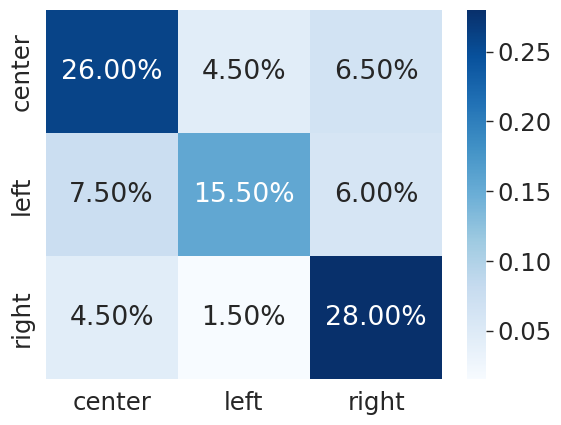

In [148]:
target_names = ['center', 'left', 'right']
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(true, preds)
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),
    annot=True, fmt='.2%', cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names)

In [149]:
import tensorflow as tf

y_pred = Baseline.predict(Baseline_test)
test_y = tf.keras.utils.to_categorical(
    test['label_enc'], num_classes=3)
y_proba_cb = Baseline._predict_proba_lr(Baseline_test)

In [150]:
from sklearn.metrics import f1_score ,mean_absolute_error, accuracy_score

print('F1:',f1_score(y_pred, y_test, average='macro'))
scores_F1['Baseline'] = f1_score(y_pred, y_test, average='macro')
print('Accuracy:',accuracy_score(y_pred, y_test))
scores_Accuracy['Baseline'] = accuracy_score(y_pred, y_test)
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['Baseline'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.5769062661762998
Accuracy: 0.5805658056580566
MAE: 0.40826461862632873


## LightGBM

In [151]:
import lightgbm as lgb
LightGBM = lgb.LGBMClassifier()

In [152]:
LightGBM_test = test_vec

In [153]:
LightGBM.fit(train_vec, y_train)

LGBMClassifier()

In [154]:
preds, true = ensemble_pred(LightGBM,test)

In [155]:
print('Ensemble F1:',f1_score(preds, true, average='macro'))
scores_F1_ensemble['LightGBM'] = f1_score(preds, true, average='macro')
print('Ensemble Accuracy:',accuracy_score(preds, true))
scores_Accuracy_ensemble['LightGBM'] = accuracy_score(preds, true)

Ensemble F1: 0.6814582123435932
Ensemble Accuracy: 0.685


<Axes: >

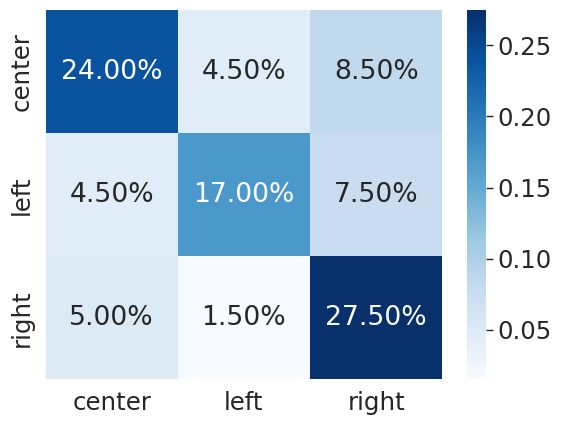

In [156]:
target_names = ['center', 'left', 'right']
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(true, preds)
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),
    annot=True, fmt='.2%', cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names)

In [157]:
import tensorflow as tf

y_pred = LightGBM.predict(LightGBM_test)
test_y = tf.keras.utils.to_categorical(
    test['label_enc'], num_classes=3)
y_proba_cb = LightGBM.predict_proba(LightGBM_test)

In [158]:
from sklearn.metrics import f1_score ,mean_absolute_error, accuracy_score

print('F1:',f1_score(y_pred, y_test, average='macro'))
scores_F1['LightGBM'] = f1_score(y_pred, y_test, average='macro')
print('Accuracy:',accuracy_score(y_pred, y_test))
scores_Accuracy['LightGBM'] = accuracy_score(y_pred, y_test)
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['LightGBM'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.5676413117071567
Accuracy: 0.5713407134071341
MAE: 0.33207643729356456


## BERT

In [276]:
train.loc[train["lemmas"] == "", "lemmas"] = np.nan
test.loc[test["lemmas"] == "", "lemmas"] = np.nan
val.loc[val["lemmas"] == "", "lemmas"] = np.nan

In [277]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5223 entries, 10 to 911
Columns: 307 entries, title to feature_bracelet
dtypes: float64(300), int64(1), object(6)
memory usage: 12.3+ MB


In [278]:
train = train.dropna()
val = val.dropna()
test = test.dropna()

In [279]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5209 entries, 10 to 911
Columns: 307 entries, title to feature_bracelet
dtypes: float64(300), int64(1), object(6)
memory usage: 12.2+ MB


In [280]:
y_train = train['label_enc']
y_test = test['label_enc']
y_val = val['label_enc']

In [281]:
!pip install tensorflow_hub
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [282]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.optimizers.legacy import Adam

In [283]:
def build_classifier_model():
    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name='preprocessing')
    
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(
        tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.Dense(
        3, activation='softmax', name='classifier')(net)
    model = tf.keras.Model(text_input, net)
    loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')
    metric = tf.metrics.CategoricalAccuracy('accuracy')
    optimizer = Adam(
        learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
    model.compile(
        optimizer=optimizer, loss=loss, metrics=metric)
    model.summary()
    return model

In [284]:
tfhub_handle_encoder = \
    'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1'#"https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = \
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [285]:
BERT = build_classifier_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [286]:
y_train = tf.keras.utils.to_categorical(
    train['label_enc'], num_classes=3)
y_val = tf.keras.utils.to_categorical(
    val['label_enc'], num_classes=3)

history = BERT.fit(
    x = train['lemmas'].values,
    y = y_train,
    validation_data=(val['lemmas'].values, y_val),
    epochs=8)

Epoch 1/8
163/163 [==============================] - 275s 1s/step - loss: 1.2015 - accuracy: 0.5011 - val_loss: 0.9437 - val_accuracy: 0.5518
Epoch 2/8
163/163 [==============================] - 223s 1s/step - loss: 0.7307 - accuracy: 0.6940 - val_loss: 1.0253 - val_accuracy: 0.5753
Epoch 3/8
163/163 [==============================] - 225s 1s/step - loss: 0.4548 - accuracy: 0.8207 - val_loss: 1.2428 - val_accuracy: 0.5828
Epoch 4/8
163/163 [==============================] - 225s 1s/step - loss: 0.2811 - accuracy: 0.8946 - val_loss: 1.4289 - val_accuracy: 0.5694
Epoch 5/8
163/163 [==============================] - 225s 1s/step - loss: 0.1784 - accuracy: 0.9399 - val_loss: 1.6330 - val_accuracy: 0.5736
Epoch 6/8
163/163 [==============================] - 228s 1s/step - loss: 0.1199 - accuracy: 0.9612 - val_loss: 1.7813 - val_accuracy: 0.5694
Epoch 7/8
163/163 [==============================] - 223s 1s/step - loss: 0.0825 - accuracy: 0.9727 - val_loss: 1.9208 - val_accuracy: 0.5736
Epoch 

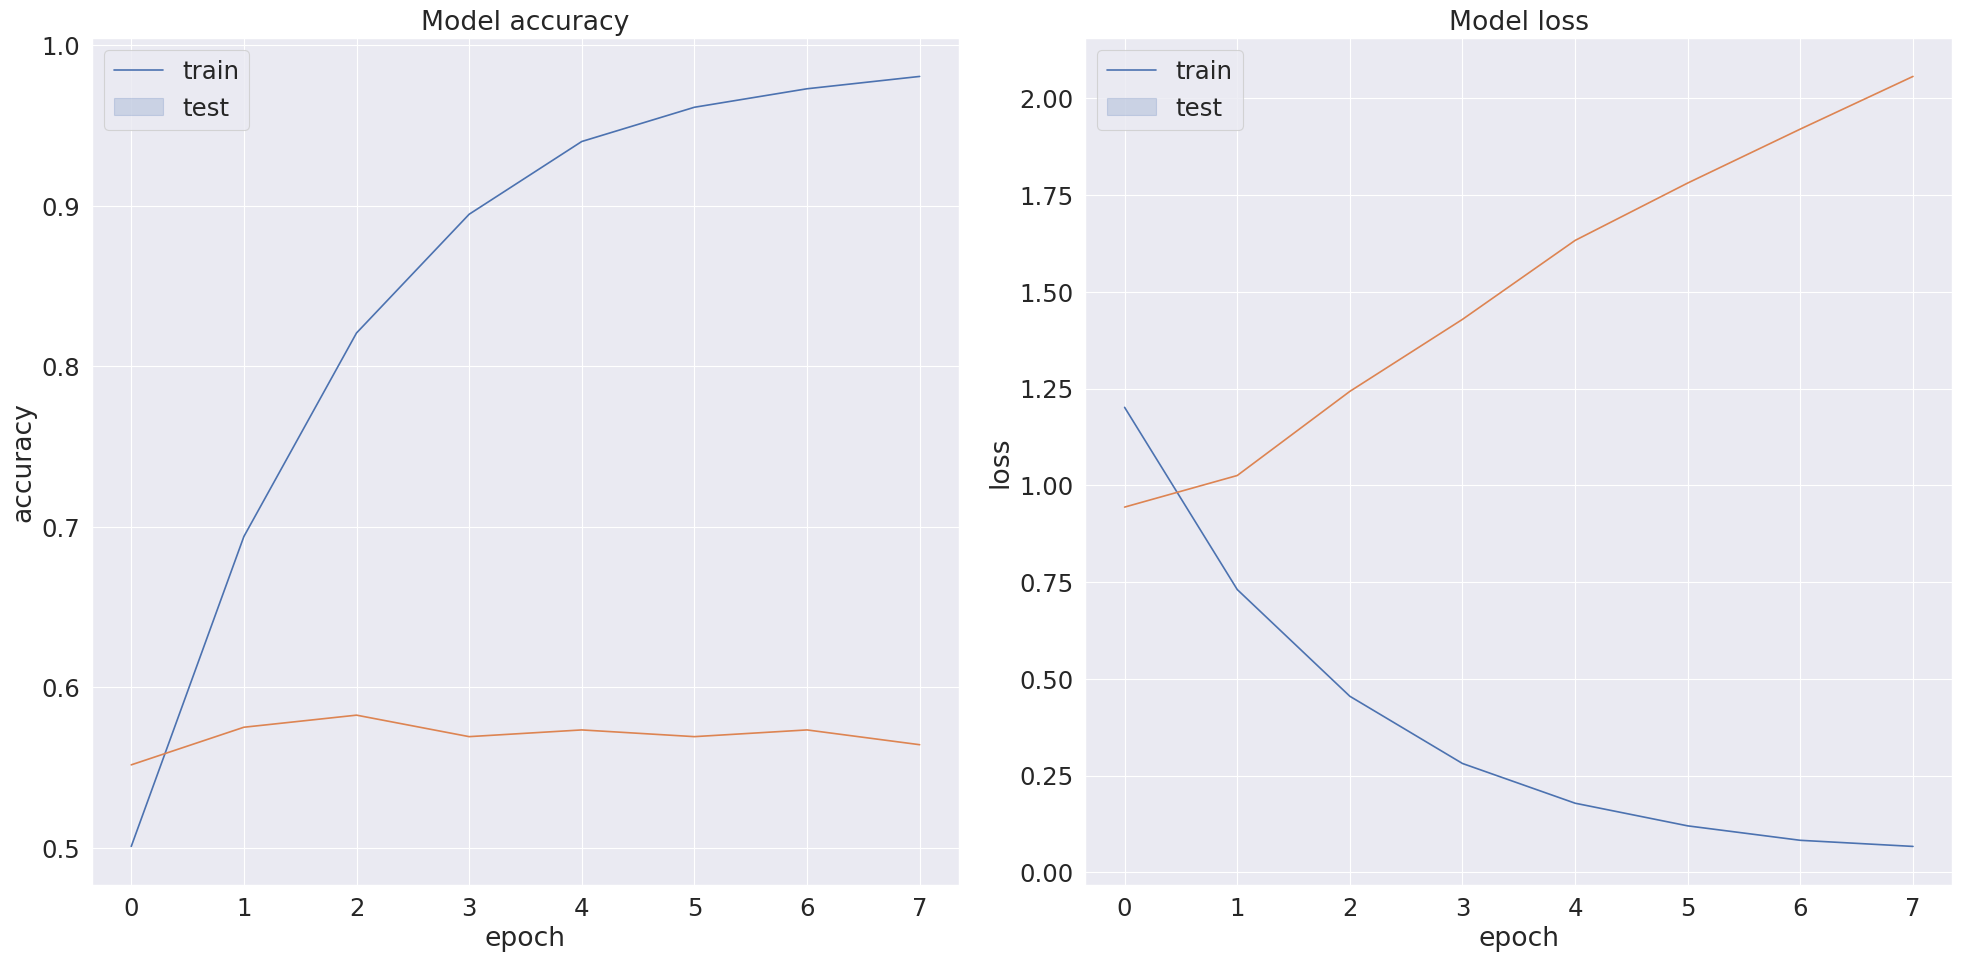

In [287]:
sns.set()
sns.set_context("paper", font_scale=2) 

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
sns.lineplot(ax=ax1, data=history.history['accuracy'])
sns.lineplot(ax=ax1, data=history.history['val_accuracy'])
ax1.set(
    title=f"Model accuracy",
    xlabel="epoch",
    ylabel="accuracy"
)
ax1.legend(['train', 'test'], loc='upper left')
ax2 = fig.add_subplot(122)
sns.lineplot(ax=ax2, data=history.history['loss'])
sns.lineplot(ax=ax2, data=history.history['val_loss'])
ax2.set(
    title=f"Model loss",
    xlabel="epoch",
    ylabel="loss"
)
ax2.legend(['train', 'test'], loc='upper left')

fig.tight_layout()
plt.show(fig) 

In [288]:
y_test = tf.keras.utils.to_categorical(
    test['label_enc'].astype('category'), num_classes=3)

In [289]:
BERT_test = test['lemmas'].values

In [290]:
def ensemble_pred(model,test):
  predictions = []
  links = np.array(test['link'])
  true_predict = np.array(test[test['link'].isin(links)]['label_enc']) 
  test_df = pd.DataFrame({'link':links,'label_enc':true_predict})
  test_df = test_df.drop_duplicates()
  links_unique = np.unique(links)
  for link_u in test_df.link:
    test_link_u = test[test['link'] == link_u]['lemmas'].values
    model_preds_u = model.predict(test_link_u)
    model_preds_u = np.argmax(model_preds_u, axis=1)
    predictions.append(np.bincount(model_preds_u).argmax())
  return predictions, np.array(test_df.label_enc)

In [291]:
preds, true = ensemble_pred(BERT,test)

1/1 [==============================] - 0s 57ms/step


In [292]:
print('F1:',f1_score(preds, true, average='macro'))
scores_F1_ensemble['BERT'] = f1_score(preds, true, average='macro')
print('Accuracy:',accuracy_score(preds, true))
scores_Accuracy_ensemble['BERT'] = accuracy_score(preds, true)

F1: 0.7094563951706808
Accuracy: 0.71


<Axes: >

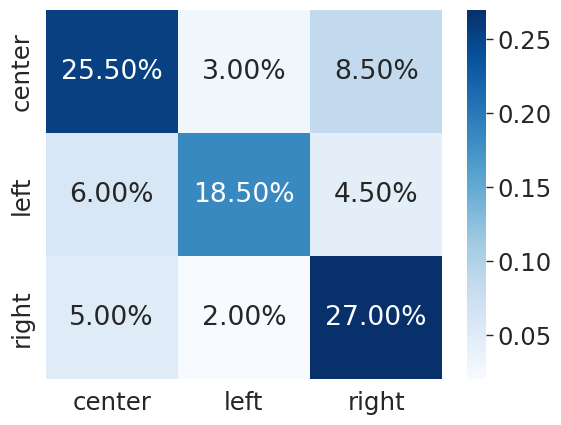

In [293]:
target_names = ['center', 'left', 'right']
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(true, preds)
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),
    annot=True, fmt='.2%', cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names)

In [294]:
y_proba_cb = BERT.predict(BERT_test)
y_pred = np.argmax(y_proba_cb, axis=1)
test_y = tf.keras.utils.to_categorical(
    test['label_enc'], num_classes=3)

51/51 [==============================] - 24s 484ms/step


In [295]:
from sklearn.metrics import f1_score ,mean_absolute_error, accuracy_score

print('F1:',f1_score(y_pred, np.argmax(y_test,axis = 1), average='macro'))
scores_F1['BERT'] = f1_score(y_pred, np.argmax(y_test,axis = 1), average='macro')
print('Accuracy:',accuracy_score(y_pred, np.argmax(y_test,axis = 1)))
scores_Accuracy['BERT'] = accuracy_score(y_pred, np.argmax(y_test,axis = 1))
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['BERT'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.5622601188455955
Accuracy: 0.5639606396063961
MAE: 0.2991177


## Catboost


In [159]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 17.4 MB/s eta 0:00:00


In [160]:
train

,title,content,label,link,all_text,lemmas,label_enc,feature_biden,feature_trump,feature_israel,...,feature_poynter newsletter,feature_earned media,feature_love,feature_bust poptarts,feature_arab,feature_high winds,feature_mamut,feature_poll,feature_freelancers,feature_bracelet
10,An App Called Libby and the Surprisingly Big B...,"Steve Potash , the bearded and bespectacled pr...",left,newyorker.com,An App Called Libby and the Surprisingly Big B...,called libby surprisingly business library boo...,1,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,The Power of Police Unions,The recent repeal of Section 50-A of the New Y...,left,newyorker.com,The Power of Police UnionsThe recent repeal of...,power police unionsthe recent repeal section y...,1,0.000000,0.062447,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,"Daily Cartoon: Thursday, May 6th",© 2021 Condé Nast .\nAll rights reserved .\nUs...,left,newyorker.com,"Daily Cartoon: Thursday, May 6th© 2021 Condé N...",daily cartoon thursday cond nast rights reserv...,1,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,What to Stream: Billy Woodberry’s Documentary ...,One of the monstrous failings of American cine...,left,newyorker.com,What to Stream: Billy Woodberry’s Documentary ...,stream billy woodberry documentary poet kaufma...,1,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,R. & B. Nostalgia Embraces Rap Influence on “C...,"Over the past four decades , hip-hop and R. & ...",left,newyorker.com,R. & B. Nostalgia Embraces Rap Influence on “C...,nostalgia embraces influence cheers best memor...,1,0.000000,0.000000,0.0,...,0.0,0.0,0.013659,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,Rep. Marjorie Taylor Greene Introduces a Bill ...,Congresswoman Marjorie Taylor Greene ( R-GA ) ...,right,thetruthaboutguns.com,Rep. Marjorie Taylor Greene Introduces a Bill ...,marjorie taylor greene introduces bill abolish...,2,0.017241,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
908,"Joe Biden is Selling Guns at a Blistering, Wor...",Joe Biden may not know what time it is at any ...,right,thetruthaboutguns.com,"Joe Biden is Selling Guns at a Blistering, Wor...",biden selling guns blistering world record pac...,2,0.032313,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
909,A Sign of Things to Come? Gun Control Bill Fai...,"As we mentioned yesterday , firearm sales — in...",right,thetruthaboutguns.com,A Sign of Things to Come? Gun Control Bill Fai...,sign things come control bill fails pass calif...,2,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
910,Gear Review: Q Side Chick Rifle Chassis,I have to admit that I really never knew much ...,right,thetruthaboutguns.com,Gear Review: Q Side Chick Rifle ChassisI have ...,gear review side chick rifle chassisi admit re...,2,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
np.array(train.columns)

array(['title', 'content', 'label', 'link', 'all_text', 'lemmas',
       'label_enc', 'feature_biden', 'feature_trump', 'feature_israel',
       'feature_trans', 'feature_lgbtq', 'feature_data',
       'feature_attribution international', 'feature_commons attribution',
       'feature_international license', 'feature_licensed creative',
       'feature_work licensed', 'feature_right wing', 'feature_workers',
       'feature_attribution', 'feature_abortion', 'feature_cision',
       'feature_women', 'feature_creative commons',
       'feature_president trump', 'feature_black',
       'feature_opinions matter', 'feature_want opinions',
       'feature_stories want', 'feature_hamas', 'feature_queer',
       'feature_thunderstorms', 'feature_workers world',
       'feature_able find', 'feature_said', 'feature_jewish',
       'feature_commons', 'feature_capitalism', 'feature_fact checking',
       'feature_democrats', 'feature_center stateless', 'feature_islam',
       'feature_licensed', '

### Только на фичах

In [213]:
df_train = train[np.array(train.columns)[7:]]
y_train = train['label_enc']
df_val = val[np.array(train.columns)[7:]]
y_val = val['label_enc']
df_test = test[np.array(train.columns)[7:]]
y_test = test['label_enc']

In [214]:
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [217]:
from catboost import CatBoostClassifier
from catboost import Pool


def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        loss_function='MultiClass',
        class_weights=class_weights,
        iterations=1000,
        learning_rate=0.1,
        eval_metric='MultiClass',
        use_best_model= True,
        task_type='GPU',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=500,
    )

In [218]:
train_pool = Pool(
    df_train, y_train, 
)

validation_pool = Pool(
    df_val, y_val, 
)

test_pool = Pool(
    df_test, y_test, 
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

Catboost_fit = fit_model(train_pool, validation_pool)

Train dataset shape: (5223, 300)



0:	learn: 1.0838238	test: 1.0888483	best: 1.0888483 (0)	total: 22.8ms	remaining: 22.8s
500:	learn: 0.6511842	test: 0.9952357	best: 0.9756589 (139)	total: 8.39s	remaining: 8.35s
999:	learn: 0.5593320	test: 1.0314060	best: 0.9756589 (139)	total: 11.9s	remaining: 0us
bestTest = 0.9756589478
bestIteration = 139
Shrink model to first 140 iterations.


In [219]:
Catboost_fit_test = test_pool

In [220]:
y_proba_cb = Catboost_fit.predict_proba(Catboost_fit_test)
y_pred = np.argmax(y_proba_cb, axis=1)

In [221]:
import tensorflow as tf
test_y = tf.keras.utils.to_categorical(
    test['label_enc'], num_classes=3)

In [222]:
def ensemble_pred(model,test):
  
  predictions = []
  links = np.array(test['link'])
  true_predict = np.array(test[test['link'].isin(links)]['label_enc']) 
  test_df = pd.DataFrame({'link':links,'label_enc':true_predict})
  test_df = test_df.drop_duplicates()
  links_unique = np.unique(links)
  for link_u in test_df.link:
    test_link_u = test[test['link'] == link_u]
    test_link_u = test_link_u[np.array(test_link_u.columns)[7:]]
    test_pool = Pool(df_test)
    model_preds_u = model.predict(test_link_u)
    pred = []
    for k in model_preds_u:
      pred.append(k[0])
    predictions.append(np.bincount(np.array(pred)).argmax())
  return predictions, np.array(test_df.label_enc)

In [223]:
preds, true = ensemble_pred(Catboost_fit,test)

In [224]:
print('Ensemble F1:',f1_score(preds, true, average='macro'))
scores_F1_ensemble['Catboost_only_features'] = f1_score(preds, true, average='macro')
print('Ensemble Accuracy:',accuracy_score(preds, true))
scores_Accuracy_ensemble['Catboost_only_features'] = accuracy_score(preds, true)

Ensemble F1: 0.6213093167526916
Ensemble Accuracy: 0.625


<Axes: >

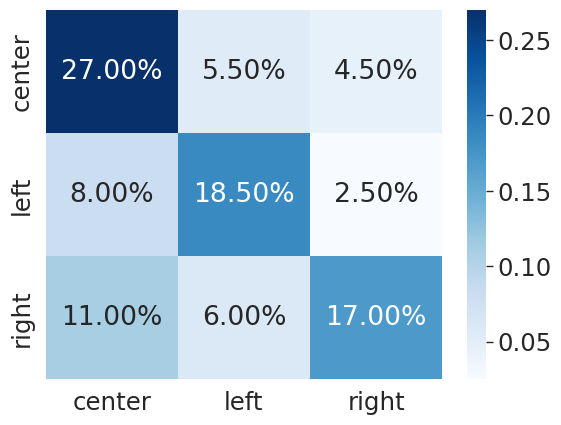

In [225]:
target_names = ['center', 'left', 'right']
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(true, preds)
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),
    annot=True, fmt='.2%', cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names)

In [226]:
from sklearn.metrics import f1_score ,mean_absolute_error, accuracy_score

print('F1:',f1_score(y_pred, y_test, average='macro'))
scores_F1['Catboost_only_features'] = f1_score(y_pred, y_test, average='macro')
print('Accuracy:',accuracy_score(y_pred, y_test))
scores_Accuracy['Catboost_only_features'] = accuracy_score(y_pred, y_test)
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['Catboost_only_features'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.5368234806836666
Accuracy: 0.5375153751537516
MAE: 0.37538552584519985


### Леммы+фичи

In [227]:
np.array(train.columns)[7:23]

array(['feature_biden', 'feature_trump', 'feature_israel',
       'feature_trans', 'feature_lgbtq', 'feature_data',
       'feature_attribution international', 'feature_commons attribution',
       'feature_international license', 'feature_licensed creative',
       'feature_work licensed', 'feature_right wing', 'feature_workers',
       'feature_attribution', 'feature_abortion', 'feature_cision'],
      dtype=object)

In [228]:
col = ['title', 'content','all_text', 'lemmas','feature_biden', 'feature_trump', 'feature_israel',
       'feature_trans', 'feature_lgbtq', 'feature_data',
       'feature_attribution international', 'feature_commons attribution',
       'feature_international license', 'feature_licensed creative',
       'feature_work licensed', 'feature_right wing', 'feature_workers',
       'feature_attribution', 'feature_abortion', 'feature_cision']

In [229]:
df_train = train[col]
y_train = train['label_enc']
df_val = val[col]
y_val = val['label_enc']
df_test = test[col]
y_test = test['label_enc']

In [230]:
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [231]:
from catboost import CatBoostClassifier
from catboost import Pool


def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        loss_function='MultiClass',
        class_weights=class_weights,
        iterations=2000,
        learning_rate=0.05,
        eval_metric='MultiClass',
        use_best_model= True,
        task_type='GPU',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=100,
    )

In [232]:
train_pool = Pool(
    df_train, y_train, 
    text_features=['title','all_text','lemmas','content'],
)

validation_pool = Pool(
    df_val, y_val, 
    text_features=['title','all_text','lemmas','content'],
)

test_pool = Pool(
    df_test, y_test, 
    text_features=['title','all_text','lemmas','content'],
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

Catboost = fit_model(train_pool, validation_pool)

Train dataset shape: (5223, 20)



0:	learn: 1.0757529	test: 1.0845406	best: 1.0845406 (0)	total: 35.9ms	remaining: 1m 11s
100:	learn: 0.7537394	test: 0.9725072	best: 0.9725072 (100)	total: 5.16s	remaining: 1m 37s
200:	learn: 0.6950634	test: 0.9613048	best: 0.9609795 (181)	total: 6.47s	remaining: 57.9s
300:	learn: 0.6571752	test: 0.9556376	best: 0.9555253 (295)	total: 7.78s	remaining: 43.9s
400:	learn: 0.6237749	test: 0.9506689	best: 0.9506689 (400)	total: 9.04s	remaining: 36s
500:	learn: 0.5983019	test: 0.9503807	best: 0.9496972 (464)	total: 10.2s	remaining: 30.6s
600:	learn: 0.5765631	test: 0.9471191	best: 0.9467955 (586)	total: 11.5s	remaining: 26.7s
700:	learn: 0.5585251	test: 0.9468507	best: 0.9463546 (627)	total: 12.6s	remaining: 23.4s
800:	learn: 0.5404432	test: 0.9457153	best: 0.9454993 (793)	total: 13.9s	remaining: 20.9s
900:	learn: 0.5251112	test: 0.9455502	best: 0.9447406 (857)	total: 16.4s	remaining: 20s
1000:	learn: 0.5095802	test: 0.9453926	best: 0.9447406 (857)	total: 23.5s	remaining: 23.5s
1100:	learn: 0

In [233]:
Catboost_test = test_pool

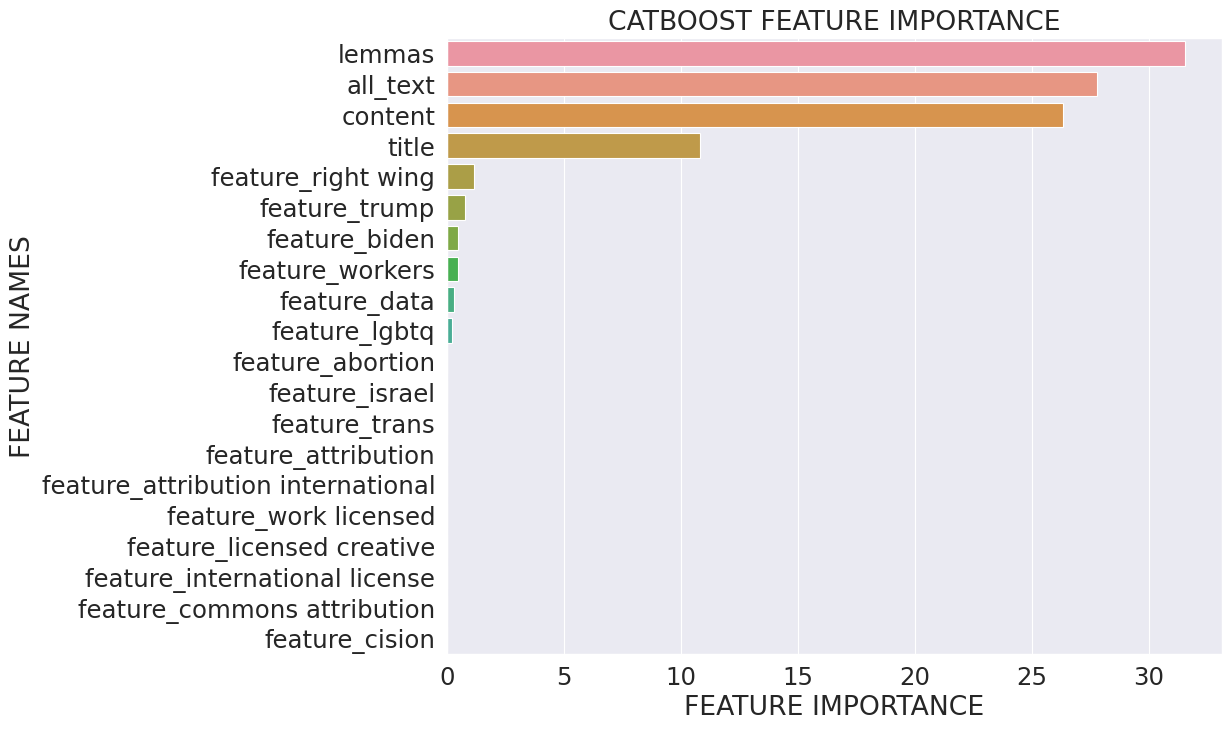

In [234]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
#plot the catboost result
plot_feature_importance(Catboost.get_feature_importance(),df_train.columns,'CATBOOST ')

In [235]:
def ensemble_pred(model,test):
  
  predictions = []
  links = np.array(test['link'])
  true_predict = np.array(test[test['link'].isin(links)]['label_enc']) 
  test_df = pd.DataFrame({'link':links,'label_enc':true_predict})
  test_df = test_df.drop_duplicates()
  links_unique = np.unique(links)
  for link_u in test_df.link:
    test_link_u = test[test['link'] == link_u]
    test_link_u = test_link_u[col]
    test_pool = Pool(test_link_u,text_features=['title','all_text','lemmas','content'])
    model_preds_u = model.predict(test_pool)
    pred = []
    for k in model_preds_u:
      pred.append(k[0])
    predictions.append(np.bincount(np.array(pred)).argmax())
  return predictions, np.array(test_df.label_enc)

In [236]:
preds, true = ensemble_pred(Catboost,test)

In [237]:
print('Ensemble F1:',f1_score(preds, true, average='macro'))
scores_F1_ensemble['Catboost'] = f1_score(preds, true, average='macro')
print('Ensemble Accuracy:',accuracy_score(preds, true))
scores_Accuracy_ensemble['Catboost'] = accuracy_score(preds, true)

Ensemble F1: 0.7266385774184295
Ensemble Accuracy: 0.725


<Axes: >

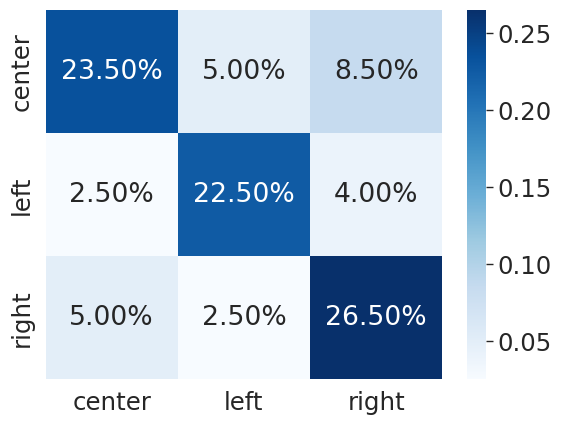

In [238]:
target_names = ['center', 'left', 'right']
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(true, preds)
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),
    annot=True, fmt='.2%', cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names)

In [239]:
y_proba_cb = Catboost.predict_proba(Catboost_test)
y_pred = np.argmax(y_proba_cb, axis=1)

In [240]:
import tensorflow as tf
test_y = tf.keras.utils.to_categorical(
    test['label_enc'], num_classes=3)

In [241]:
from sklearn.metrics import f1_score ,mean_absolute_error, accuracy_score

print('F1:',f1_score(y_pred, y_test, average='macro'))
scores_F1['Catboost'] = f1_score(y_pred, y_test, average='macro')
print('Accuracy:',accuracy_score(y_pred, y_test))
scores_Accuracy['Catboost'] = accuracy_score(y_pred, y_test)
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['Catboost'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.6202534292825382
Accuracy: 0.6211562115621156
MAE: 0.31982125398816624


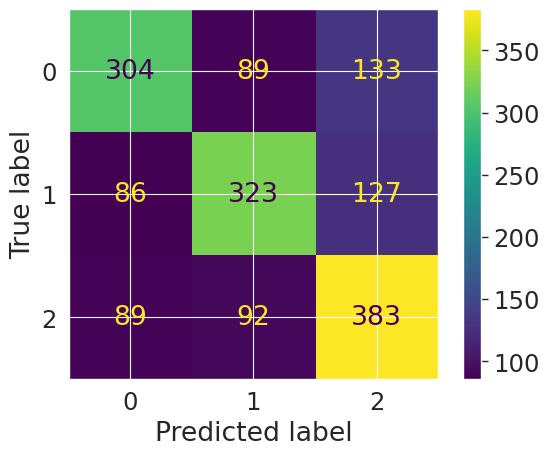

In [242]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

<Axes: >

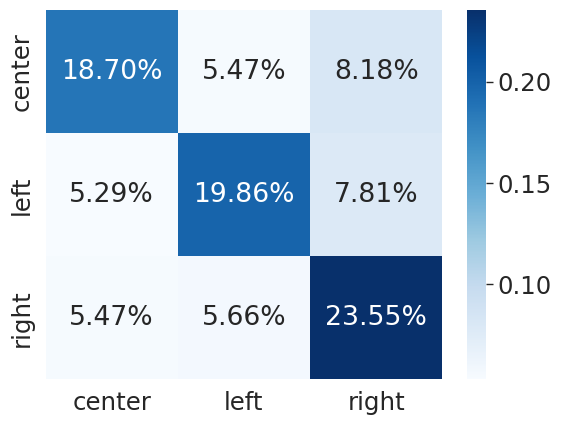

In [243]:
target_names = ['center', 'left', 'right']
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),
    annot=True, fmt='.2%', cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names)

In [244]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      center       0.63      0.58      0.60       526
        left       0.64      0.60      0.62       536
       right       0.60      0.68      0.63       564

    accuracy                           0.62      1626
   macro avg       0.62      0.62      0.62      1626
weighted avg       0.62      0.62      0.62      1626



## XGBoost

In [245]:
from xgboost import XGBClassifier

In [246]:
XGBoost = XGBClassifier(tree_method='gpu_hist',max_depth=10,n_estimators=128)

In [247]:
y_train = train[['label_enc']]

In [248]:
train_vec_1 = np.array(train[np.array(train.columns)[7:]])

In [249]:
XGBoost.fit(train_vec_1, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=128, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [250]:
test_vec_1 = np.array(test[np.array(test.columns)[7:]])

In [251]:
XGBoost_test = test_vec_1

In [264]:
def ensemble_pred(model,test):
  predictions = []
  links = np.array(test['link'])
  true_predict = np.array(test[test['link'].isin(links)]['label_enc']) 
  test_df = pd.DataFrame({'link':links,'label_enc':true_predict})
  test_df = test_df.drop_duplicates()
  links_unique = np.unique(links)
  for link_u in test_df.link:
    test_link_u = test[test['link'] == link_u]
    test_link_u_vec = np.array(test_link_u[np.array(test.columns)[7:]])
    model_preds_u = model.predict(test_link_u_vec)
    predictions.append(np.bincount(model_preds_u).argmax())
  return predictions, np.array(test_df.label_enc)

In [265]:
preds, true = ensemble_pred(XGBoost,test)

In [266]:
print('Ensemble F1:',f1_score(preds, true, average='macro'))
scores_F1_ensemble['XGBoost'] = f1_score(preds, true, average='macro')
print('Ensemble Accuracy:',accuracy_score(preds, true))
scores_Accuracy_ensemble['XGBoost'] = accuracy_score(preds, true)

Ensemble F1: 0.6479852954239522
Ensemble Accuracy: 0.655


<Axes: >

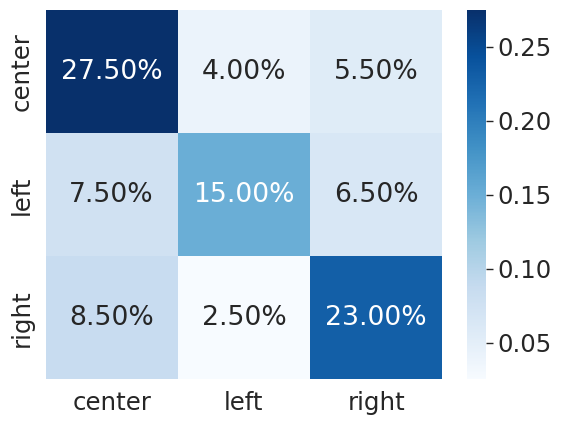

In [267]:
target_names = ['center', 'left', 'right']
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(true, preds)
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),
    annot=True, fmt='.2%', cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names)

In [268]:
y_proba_cb = XGBoost.predict_proba(XGBoost_test)
y_pred = np.argmax(y_proba_cb, axis=1)

In [269]:
test_y = tf.keras.utils.to_categorical(
    test['label_enc'], num_classes=3)

In [270]:
print('F1:',f1_score(y_pred, y_test, average='macro'))
scores_F1['XGBoost'] = f1_score(y_pred, y_test, average='macro')
print('Accuracy:',accuracy_score(y_pred, y_test))
scores_Accuracy['XGBoost'] = accuracy_score(y_pred, y_test)
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['XGBoost'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.5271659014937548
Accuracy: 0.5289052890528906
MAE: 0.3460857


## Ансамбль

In [220]:
models = [
  Baseline,
  LightGBM,
  BERT,
  Catboost_fit,
  Catboost,
  XGBoost
]

In [221]:
tests = [
  Baseline_test,
  LightGBM_test,
  BERT_test,
  Catboost_fit_test,
  Catboost_test,
  XGBoost_test
]

In [224]:
def ensemble_pred(models,tests):
  predictions = []
  for i in range(len(models)):
    if i == 2:#BERT
      y_proba_cb = models[i].predict(tests[i])
      predictions.append(np.argmax(y_proba_cb, axis=1))
    elif i == 3 or i == 4:#CatBoost
      pred_1 = models[i].predict(tests[i])
      pred = []
      for k in pred_1:
        pred.append(k[0])
      predictions.append(pred)
    else:
      pred = models[i].predict(tests[i])
      predictions.append(pred)
  predictions = np.array(predictions).T
  pred_final = []
  for pred in predictions:
    pred_final.append(np.bincount(pred).argmax())
  return pred_final

In [225]:
ans = ensemble_pred(models,tests)

47/47 [==============================] - 21s 443ms/step


In [227]:
print('F1:',f1_score(ans, y_test, average='macro'))
scores_F1['Ensemble'] = f1_score(ans, y_test, average='macro')
print('Accuracy:',accuracy_score(ans, y_test))
scores_Accuracy['Ensemble'] = accuracy_score(ans, y_test)

ValueError: ignored

In [ ]:
cm = confusion_matrix(y_test, ans)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, ans, target_names=target_names))

#Результаты

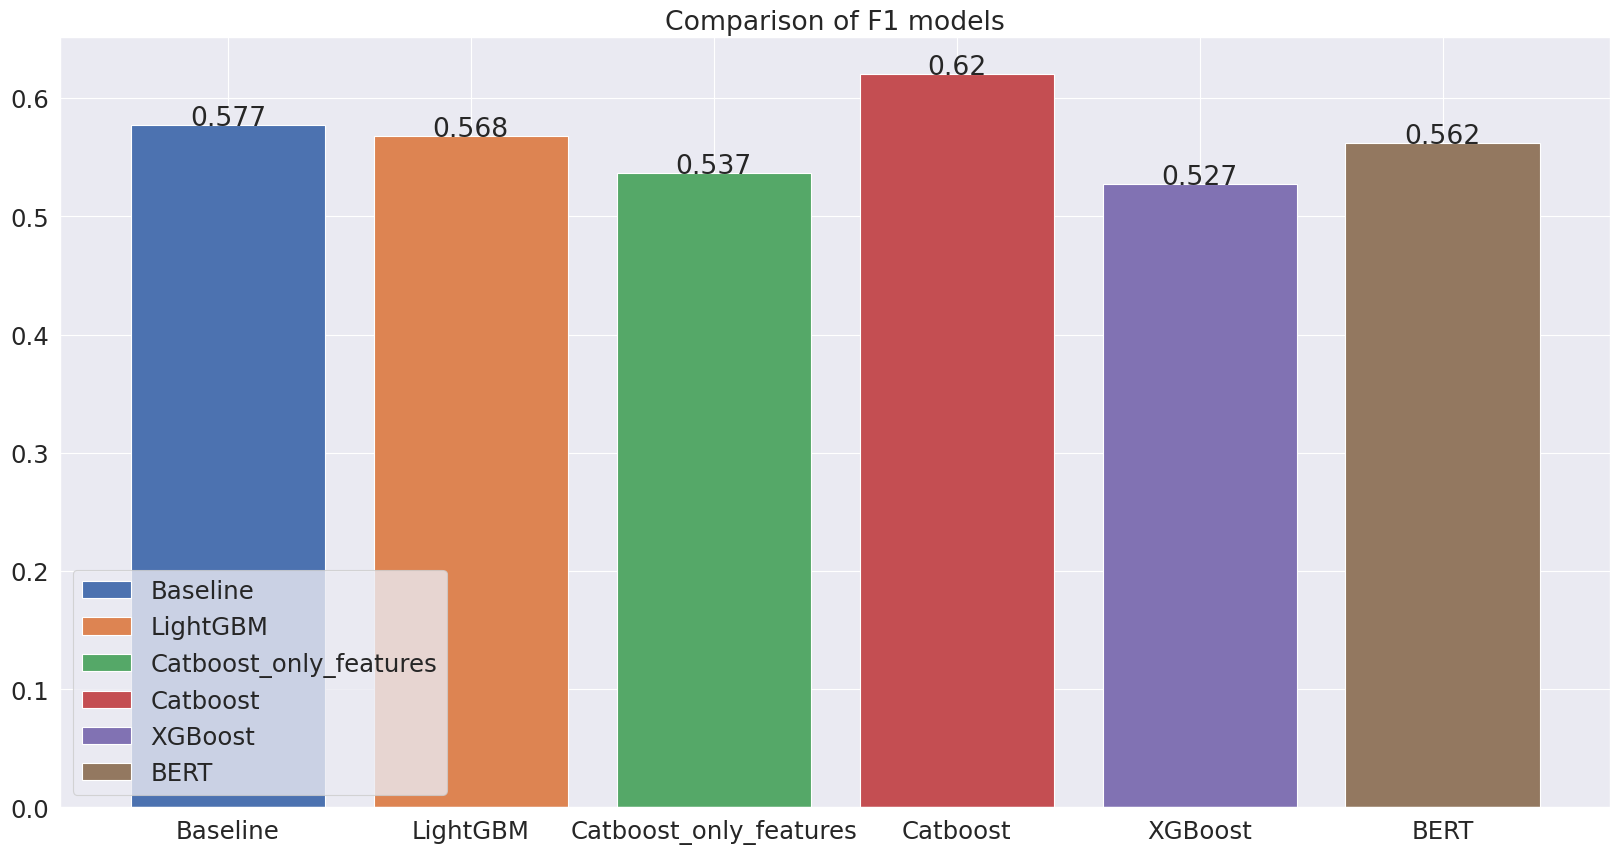

In [296]:
fig, ax = plt.subplots(figsize =(20, 10))
for i in scores_F1.keys():
  ax.bar(i,scores_F1[i], label=i)
  plt.text(i,scores_F1[i],round(scores_F1[i],3), ha = 'center')
ax.legend(loc='lower left')
plt.title("Comparison of F1 models")
plt.show()

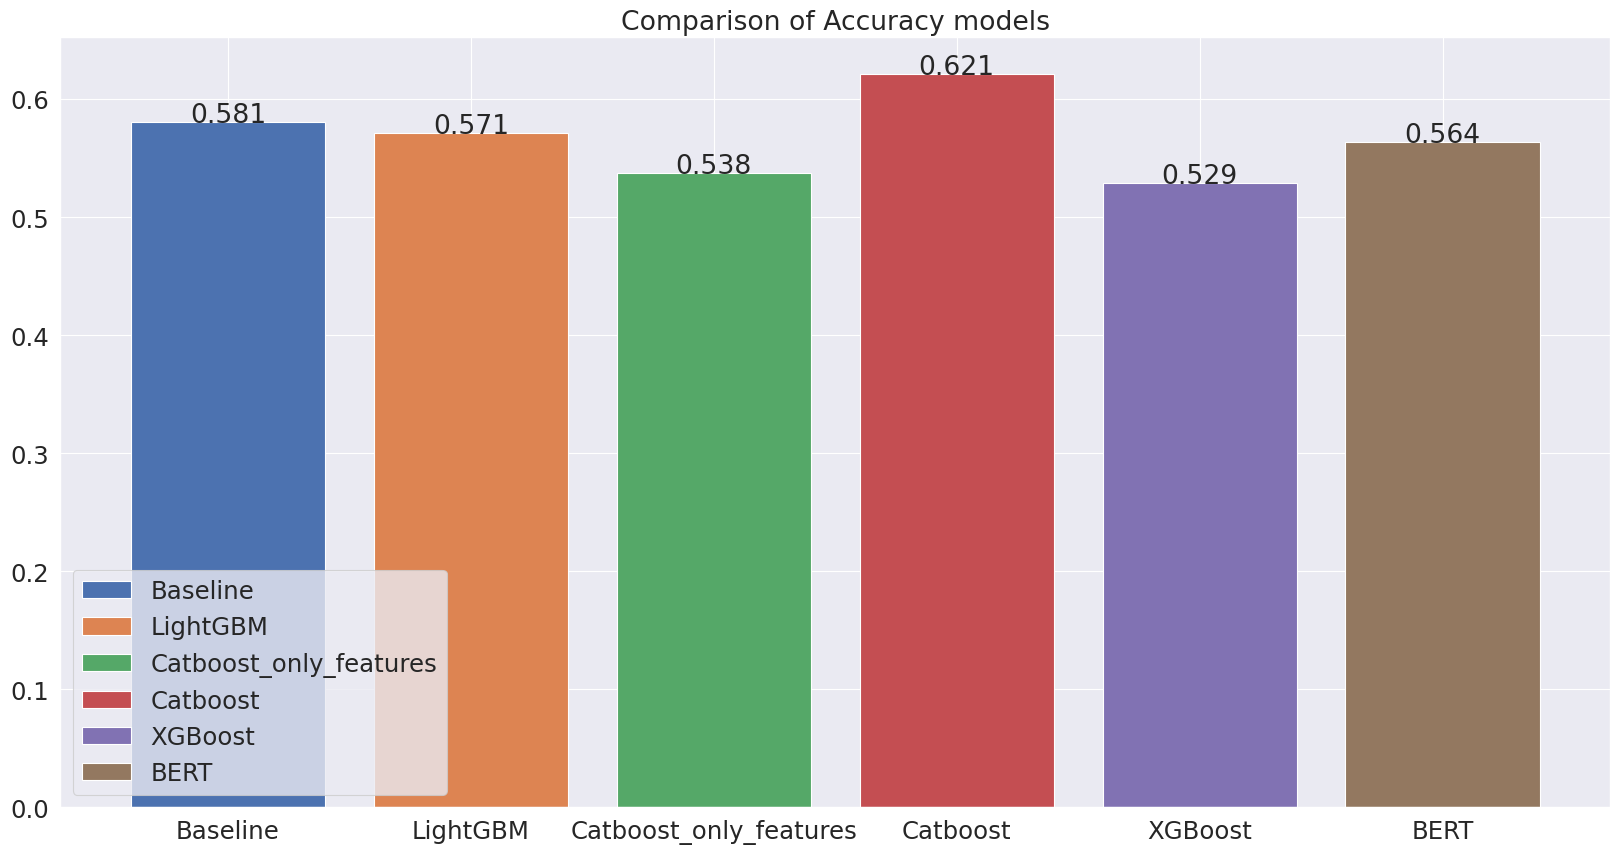

In [297]:
fig, ax = plt.subplots(figsize =(20, 10))
for i in scores_Accuracy.keys():
  ax.bar(i,scores_Accuracy[i], label=i)
  plt.text(i,scores_Accuracy[i],round(scores_Accuracy[i],3), ha = 'center')
ax.legend(loc='lower left')
plt.title("Comparison of Accuracy models")
plt.show()

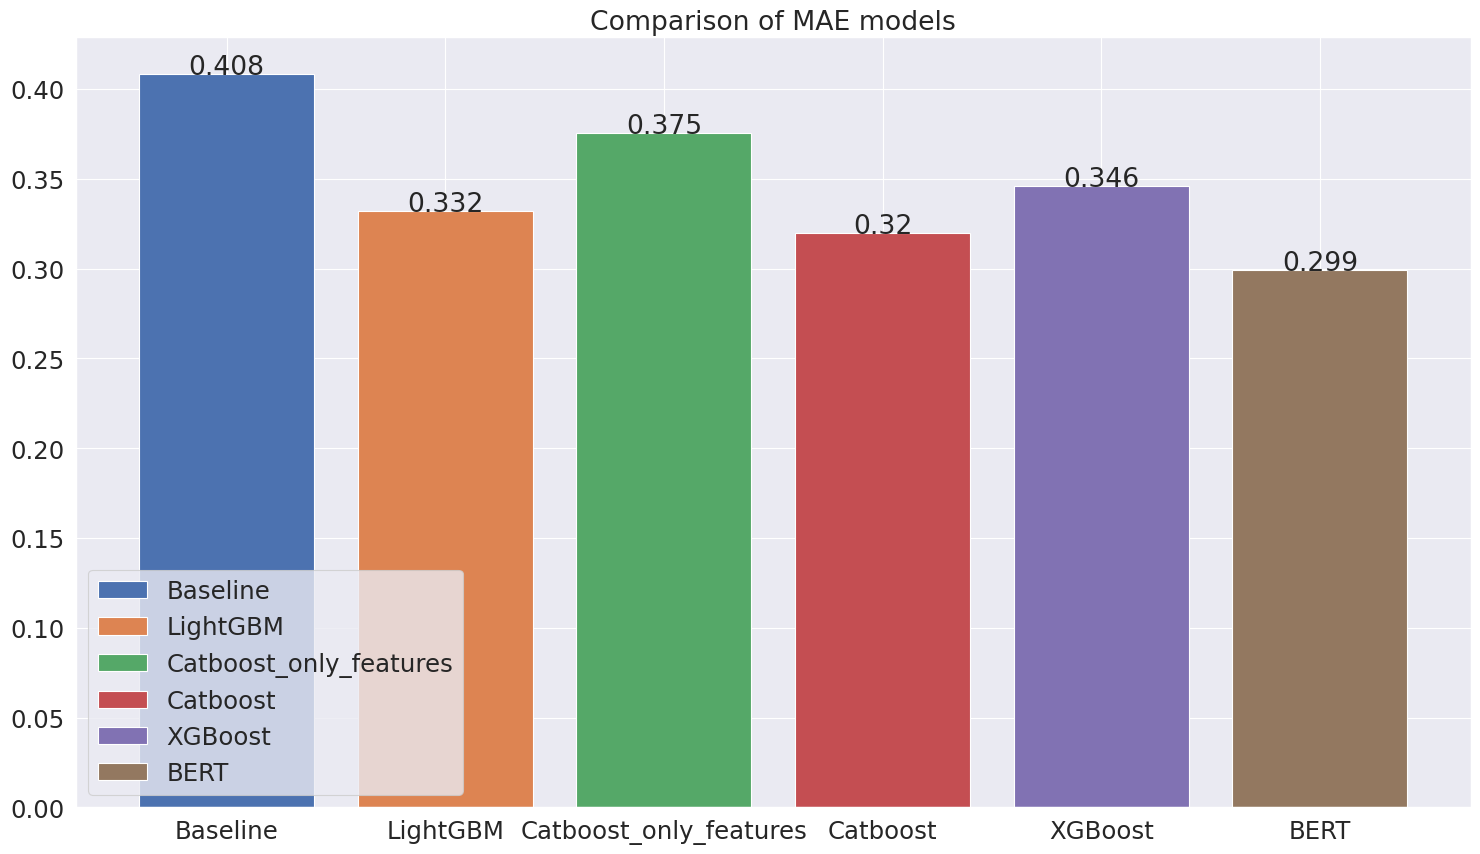

In [298]:
fig, ax = plt.subplots(figsize =(18, 10))
for i in scores_MAE.keys():
  ax.bar(i,scores_MAE[i], label=i)
  plt.text(i,scores_MAE[i],round(scores_MAE[i],3), ha = 'center')
ax.legend(loc='lower left')
plt.title("Comparison of MAE models")
plt.show()

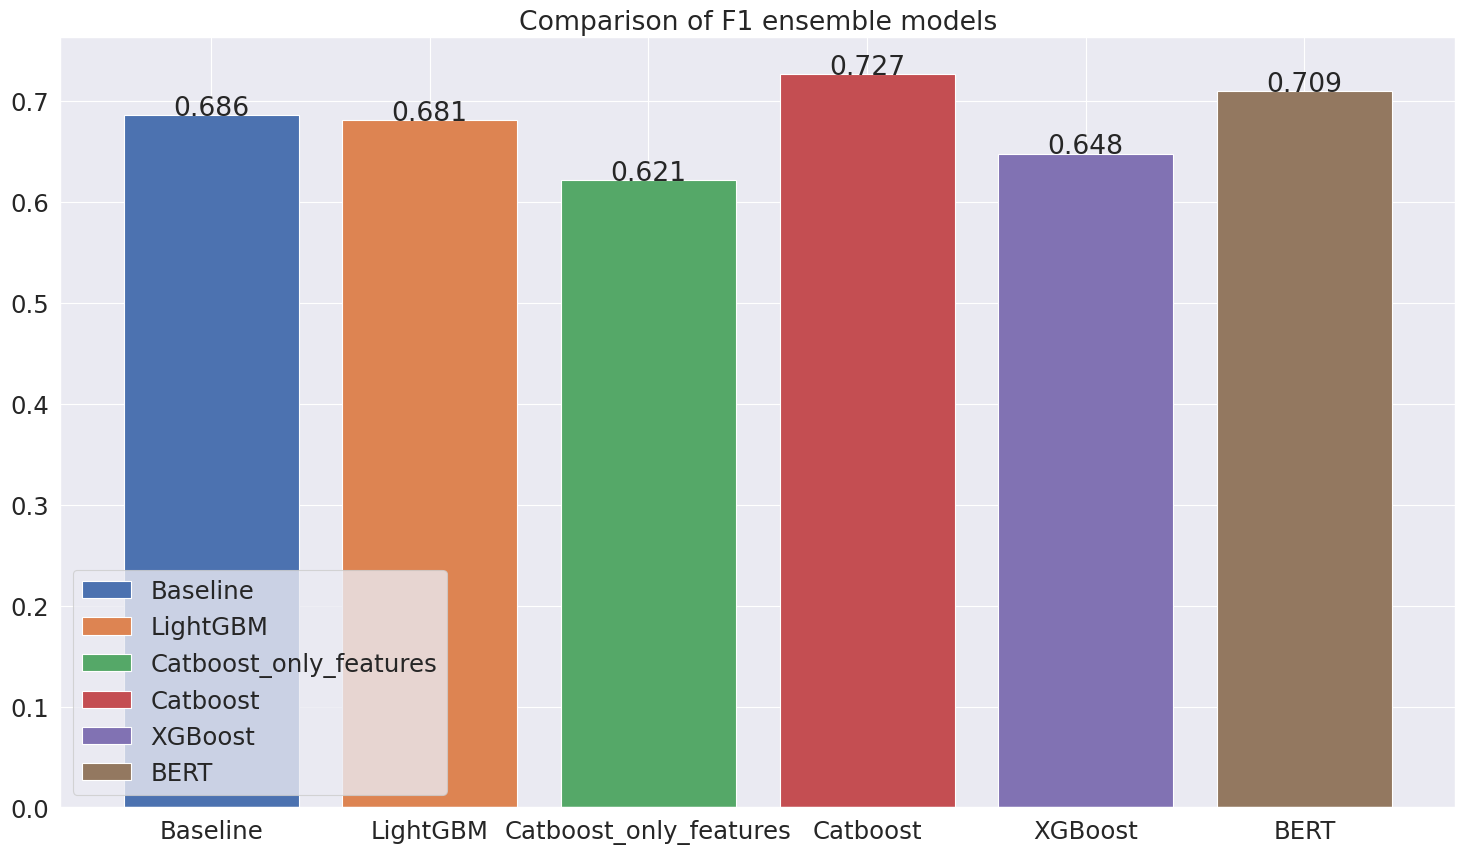

In [299]:
fig, ax = plt.subplots(figsize =(18, 10))
for i in scores_F1_ensemble.keys():
  ax.bar(i,scores_F1_ensemble[i], label=i)
  plt.text(i,scores_F1_ensemble[i],round(scores_F1_ensemble[i],3), ha = 'center')
ax.legend(loc='lower left')
plt.title("Comparison of F1 ensemble models")
plt.show()

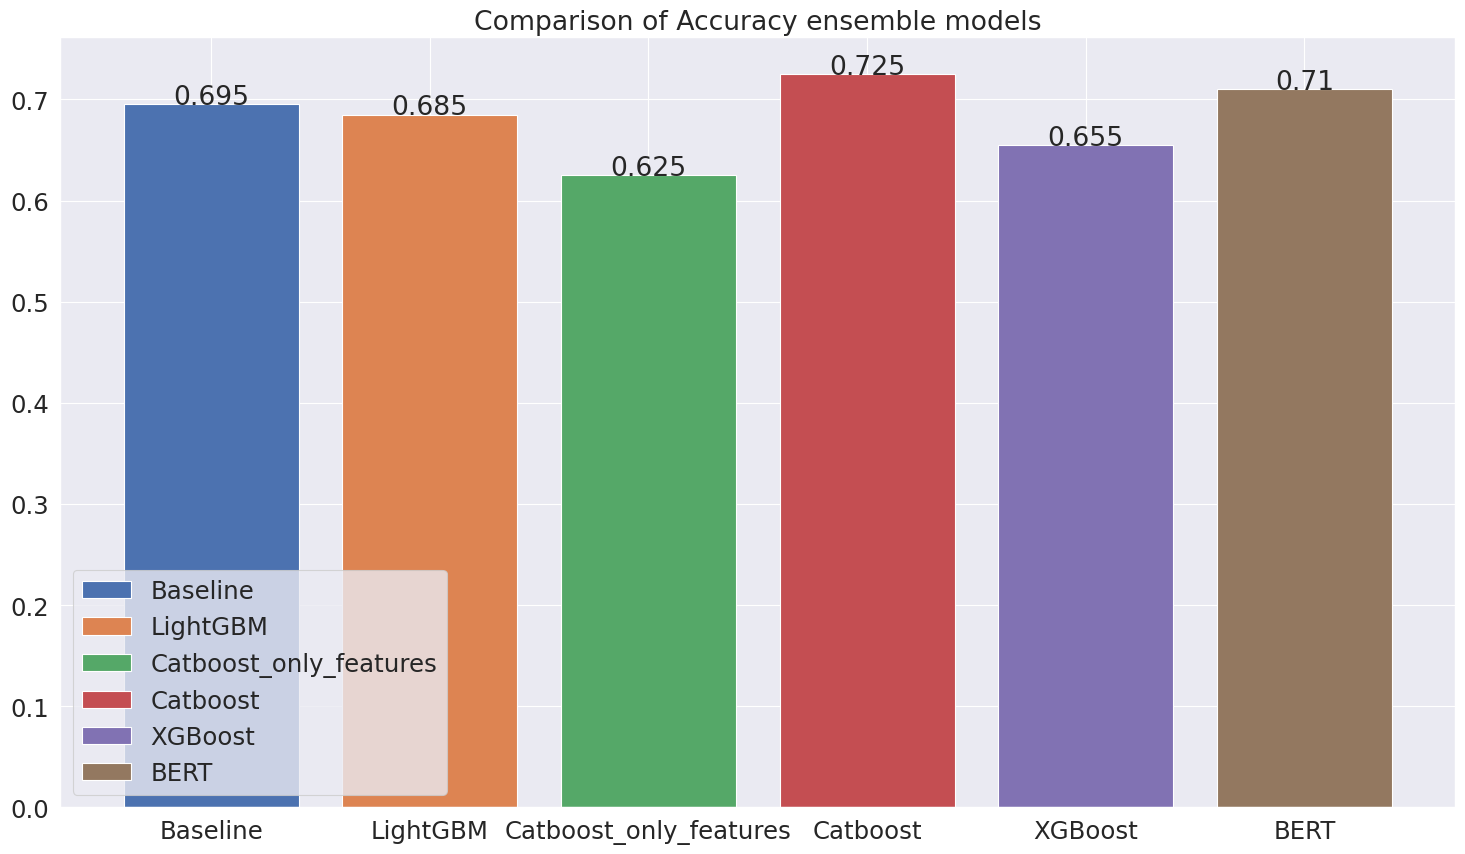

In [300]:
fig, ax = plt.subplots(figsize =(18, 10))
for i in scores_Accuracy_ensemble.keys():
  ax.bar(i,scores_Accuracy_ensemble[i], label=i)
  plt.text(i,scores_Accuracy_ensemble[i],round(scores_Accuracy_ensemble[i],3), ha = 'center')
ax.legend(loc='lower left')
plt.title("Comparison of Accuracy ensemble models")
plt.show()